# Transfer Learning
This project should introduce you to transfer learning techniques. The checklist below shows the steps necessary to finish the project.
- **Prepare a dataset**. The dataset shall be desined for image classification, and be organized to work with keras.applications (training, validation and test data should be in different folders. Images from one class should be in one subfolder). 
- **Select the network**. Select the network you want to work with. In the original code `Xception` network is selected, but you may change it if you want.
- **Complete functions**. Complete missing code in the following functions
    - `add_new_last_layer` - adds an output layer to your model. You may also add some layers in between. If so, remember to unfreeze these layers in `setup_to_transfer_learn` function
    - `setup_to_transfer_learn` - Freezes all layers but the last one and compiles the model
    - `setup_to_finetune` - Freezes the first not_trainable layers, and unfreezes the rest
    - `train_generator` - Creates a generator feed with train dataset. You should add data augmentation to it
- **Perorm training**. Perform model trainig slowly unfreezeng the layers as long as you do not observe overfitting. In case of overfitting get back to previous model.
- **Test your model on real images**. Write a code that tests your model on real images. You should display an image, a real class of an image, the class selected by the model, and the probabilities assined by the model to all the classes.

In [1]:
import os
import sys
import glob

import numpy as np
import pickle

import matplotlib.pyplot as plt

from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Nadam

%matplotlib inline

In [2]:
# Run if you are using google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Run to see how to access your google drive
!ls '/content/drive/My Drive/minidata'

test  train  valid


In [3]:
# If you have more than 1 GPU and you want to train on the first one only
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
def get_nb_files(directory):
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        print ('No directory')
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
              cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt

def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet
    Arguments:
        base_model: keras model (without a top layer)
        nb_classes: number of classes
    Returns:
        new keras model with last layer
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add the last layer and ((optionally) a dense layer
    # ENTER YOUR CODE HERE 
    predictions = Dense(nb_classes, activation="softmax")(x)
    
    #END OF YOUR CODE
    model = Model(inputs=base_model.input, outputs=predictions)
    return model



def setup_to_transfer_learn(model, args):
    """Freezes all layers but the last one and compiles the model"""
    
    # TODO: Set all the layers but last one to not trainable.
    # Note: If you added more than one layer in the add_new_last_layer 
    # function you should set all these layers to trainable.
    #ENTER YOUR CODE HERE    
    for layer in model.layers[:-1]:
      layer.trainable=False
    #END OF YOUR CODE

    model.layers[-1].trainable=True
    opt = Nadam(lr=args.lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


def setup_to_finetune(model, args, not_trainable):
    """Freezes the first not_trainable layers, and unfreezes the rest
    Arguments:
        model: keras model
        not_trainable: number of not trainable layers
    """
    
    #Set the layers [0:not_trainable] to not trainable. Set the layers [not_trainable:] to trainable
    #ENTER YOUR CODE HERE

    for layer in model.layers[:not_trainable]:
      layer.trainable=False

    for layer in model.layers[not_trainable:]:
     layer.trainable=True

    #END OF YOUR CODE

    opt = Nadam(lr=args.lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
def trainable_params(model, output_format = 'en_US'):
    """Computes the number of trainable parameters in the model.
    Args:
        model: keras model
        output_format: (default: 'en_US')
            'int'   - number of trainable parameters (12345)
            'en_US' - number of trainable parameters formated to comma separated str ('12,235')
    """    
    
    def nr_to_string(number, separator = ','):
        """
        Changes numbers to string.
        """
        s = '%d' % number
        groups = []
        while s and s[-1].isdigit():
            groups.append(s[-3:])
            s = s[:-3]
        return s + separator.join(reversed(groups))

    # And the real trainable_params function
    
    ret = sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])
    if output_format == 'en_US':
        return nr_to_string(ret)
    else:
        return ret


### Plot results

In [5]:
def unpack_history(history, old_history = None):
    if old_history is None:
        new_history = {
            'accuracy' : [],
            'val_accuracy' : [],
            'loss' : [],
            'val_loss' : [],
        }  
    else:
        new_history = old_history
    new_history['accuracy'] += history.history['accuracy']
    new_history['val_accuracy'] += history.history['val_accuracy']
    new_history['loss'] += history.history['loss']
    new_history['val_loss'] += history.history['val_loss']
    return new_history

def plot_history(training_history):
    acc = training_history['accuracy']
    val_acc = training_history['val_accuracy']
    loss = training_history['loss']
    val_loss = training_history['val_loss']
    epochs = np.arange(len(acc)) + 1
    
    fig = plt.figure(figsize=(12, 4))

    ax1 = fig.add_subplot(121)    
    ax1.plot(epochs, loss, c='g', label='Train')
    ax1.plot(epochs, val_loss, c='r', label='Valid')
    ax1.set_title('Loss')
    ax1.legend(loc='lower left');
    ax1.grid(True)
    
    ax2 = fig.add_subplot(122)    
    ax2.plot(epochs, acc, c='g', label='Train')
    ax2.plot(epochs, val_acc, c='r', label='Valid')
    ax2.set_title('Accuracy')
    #ax2.legend(loc='upper left');
    ax2.grid(True)
        
    plt.show()    


def process_and_display(history, old_history = None):
    new_history = unpack_history(history, old_history)
    plot_history(new_history)
    return new_history
    
    

### Hyperparameters

In [6]:
class Args():
    def __init__(self):
        
        self.im_width, self.im_height = 299, 299 #fixed size for Xception
        self.lr = 0.001
        self.batch_size = 32
        
        local_folder = '/content/drive/MyDrive/minidata'
        self.train_dir = os.path.join(local_folder, 'train/')
        self.valid_dir = os.path.join(local_folder, 'valid/')
        self.test_dir = os.path.join(local_folder, 'test/')
            
args = Args()


### Prepare global variables

In [7]:
nb_train_samples = get_nb_files(args.train_dir)
classes = glob.glob(args.train_dir + "/*")
classes = [x.split('/')[-1] for x in classes]
classes.sort()
nb_classes = len(classes)
nb_valid_samples = get_nb_files(args.valid_dir)

train_steps = int(nb_train_samples / args.batch_size)
valid_steps = int (nb_valid_samples / args.batch_size)

print ('Train dataset contains {} samples ({} steps / epoch)'.format(nb_train_samples, train_steps))
print ('Valid dataset contains {} samples ({} steps / epoch)'.format(nb_valid_samples, valid_steps))
print ('Dataset contains {} classes ({}).'.format(nb_classes, classes))


Train dataset contains 616 samples (19 steps / epoch)
Valid dataset contains 121 samples (3 steps / epoch)
Dataset contains 5 classes (['cat', 'chicken', 'dog', 'horse', 'spider']).


### Generators

In [8]:
# add data augmentation to the generator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #ENTER YOUR CODE
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    #END OF YOUR CODE
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    args.train_dir,
    target_size=(args.im_width, args.im_height),
    batch_size=args.batch_size,
)

validation_generator = test_datagen.flow_from_directory(
    args.valid_dir,
    target_size=(args.im_width, args.im_height),
    batch_size=args.batch_size,
)

test_generator = test_datagen.flow_from_directory(
    args.test_dir,
    target_size=(args.im_width, args.im_height),
    batch_size=args.batch_size
)

Found 616 images belonging to 5 classes.
Found 121 images belonging to 5 classes.
Found 123 images belonging to 5 classes.


### Model

In [10]:
model = Xception(weights='imagenet', include_top=False)
model = add_new_last_layer(model, nb_classes)

model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
_____________________________

## Training

### TODO: Perform training (transfer learning and fine tuning) to get the best results you can.


### Transfer learning

In [ ]:
setup_to_transfer_learn(model, args)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 5,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

Epoch 1/5
19/19 [==============================] - 231s 12s/step - loss: 1.3698 - accuracy: 0.5532 - val_loss: 0.6828 - val_accuracy: 0.9792
Epoch 2/5
19/19 [==============================] - 14s 770ms/step - loss: 0.5734 - accuracy: 0.9676 - val_loss: 0.3293 - val_accuracy: 0.9792
Epoch 3/5
19/19 [==============================] - 14s 736ms/step - loss: 0.3089 - accuracy: 0.9642 - val_loss: 0.2146 - val_accuracy: 0.9792
Epoch 4/5
19/19 [==============================] - 14s 753ms/step - loss: 0.2019 - accuracy: 0.9730 - val_loss: 0.1598 - val_accuracy: 0.9792
Epoch 5/5
19/19 [==============================] - 14s 755ms/step - loss: 0.1646 - accuracy: 0.9763 - val_loss: 0.1551 - val_accuracy: 0.9792


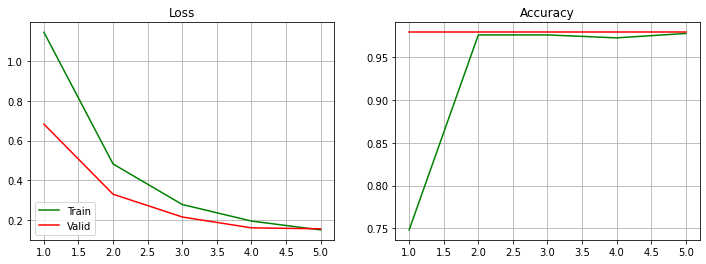

In [ ]:
tl_history = process_and_display(history)
model.save_weights('/content/drive/MyDrive/checkpoints')

### Fine tuning

In [ ]:
model.layers[126].get_config()['name']

'block14_sepconv1'

In [ ]:
setup_to_finetune(model, args, not_trainable=126)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 2,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

Epoch 1/2
19/19 [==============================] - 18s 798ms/step - loss: 0.0972 - accuracy: 0.9758 - val_loss: 0.1038 - val_accuracy: 0.9688
Epoch 2/2
19/19 [==============================] - 15s 776ms/step - loss: 0.0314 - accuracy: 0.9858 - val_loss: 0.1126 - val_accuracy: 0.9792


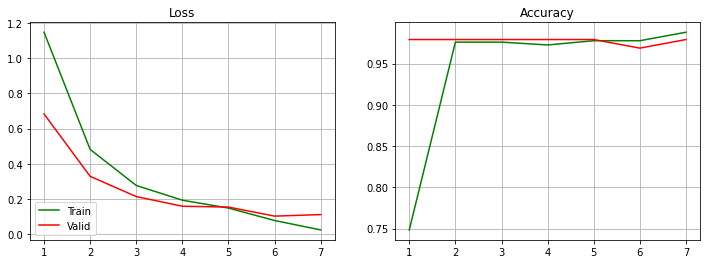

In [ ]:
ft126_history = process_and_display(history, tl_history)
model.save_weights('/content/drive/MyDrive/checkpoints/fine_tuning_126')

**You should continue unfreezeng the layers and training the model until the model overfits. Feel free to add as many code cells as you wish**.

In [ ]:
model.layers[116].get_config()['name']

'block13_sepconv1_act'

In [ ]:
setup_to_finetune(model, args, not_trainable=116)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 2,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

Epoch 1/2
19/19 [==============================] - 19s 820ms/step - loss: 0.0161 - accuracy: 0.9983 - val_loss: 1.3528 - val_accuracy: 0.8333
Epoch 2/2
19/19 [==============================] - 15s 782ms/step - loss: 0.0613 - accuracy: 0.9832 - val_loss: 0.3016 - val_accuracy: 0.9792


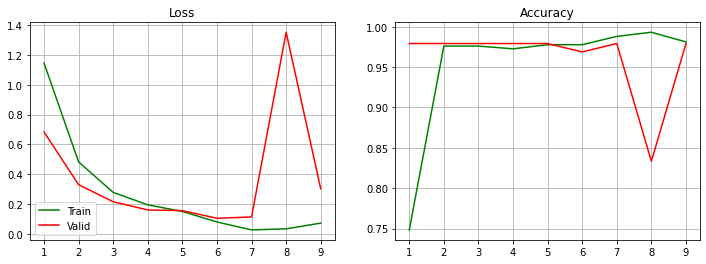

In [ ]:
ft116_history = process_and_display(history, tl_history)
model.save_weights('/content/drive/MyDrive/checkpoints/fine_tuning_116')

In [ ]:
model.layers[106].get_config()['name']

'block12_sepconv1_act'

Epoch 1/2
19/19 [==============================] - 20s 841ms/step - loss: 0.0618 - accuracy: 0.9863 - val_loss: 0.2425 - val_accuracy: 0.9792
Epoch 2/2
19/19 [==============================] - 15s 839ms/step - loss: 0.0686 - accuracy: 0.9786 - val_loss: 0.2842 - val_accuracy: 0.9896


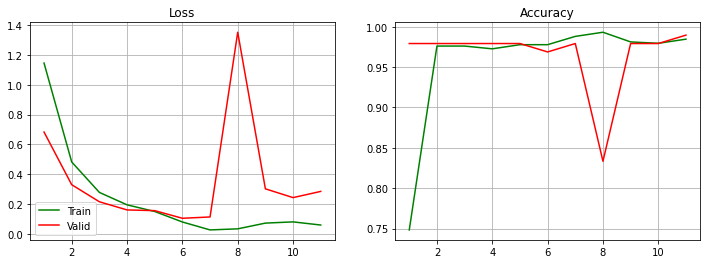

In [ ]:
setup_to_finetune(model, args, not_trainable=106)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 2,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

ft106_history = process_and_display(history, tl_history)
model.save_weights('/content/drive/MyDrive/checkpoints/fine_tuning_106')

Epoch 1/2
19/19 [==============================] - 21s 860ms/step - loss: 0.0489 - accuracy: 0.9890 - val_loss: 0.3928 - val_accuracy: 0.9688
Epoch 2/2
19/19 [==============================] - 16s 823ms/step - loss: 0.0599 - accuracy: 0.9924 - val_loss: 10.7016 - val_accuracy: 0.6771


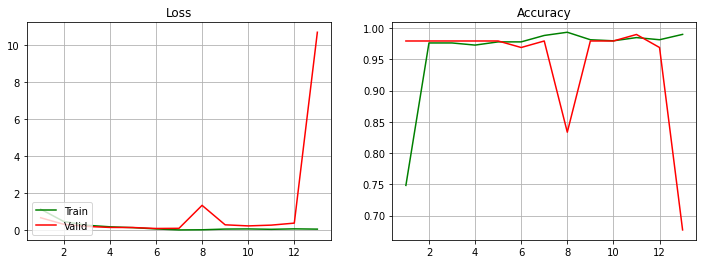

In [ ]:
setup_to_finetune(model, args, not_trainable=96)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 2,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

ft96_history = process_and_display(history, tl_history)
model.save_weights('/content/drive/MyDrive/checkpoints/fine_tuning_96')

Epoch 1/2
19/19 [==============================] - 22s 871ms/step - loss: 0.0899 - accuracy: 0.9740 - val_loss: 0.0435 - val_accuracy: 0.9792
Epoch 2/2
19/19 [==============================] - 16s 839ms/step - loss: 0.1194 - accuracy: 0.9628 - val_loss: 1.1544 - val_accuracy: 0.9167


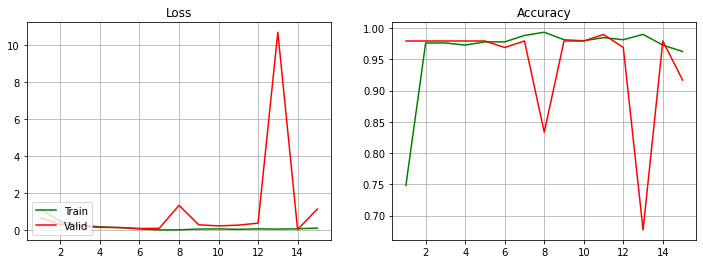

In [ ]:
setup_to_finetune(model, args, not_trainable=86)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 2,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

ft96_history = process_and_display(history, tl_history)
model.save_weights('/content/drive/MyDrive/checkpoints/fine_tuning_86')

Epoch 1/2
19/19 [==============================] - 24s 925ms/step - loss: 0.1215 - accuracy: 0.9629 - val_loss: 1.6459 - val_accuracy: 0.9271
Epoch 2/2
19/19 [==============================] - 16s 897ms/step - loss: 0.1875 - accuracy: 0.9384 - val_loss: 1.5295 - val_accuracy: 0.8854


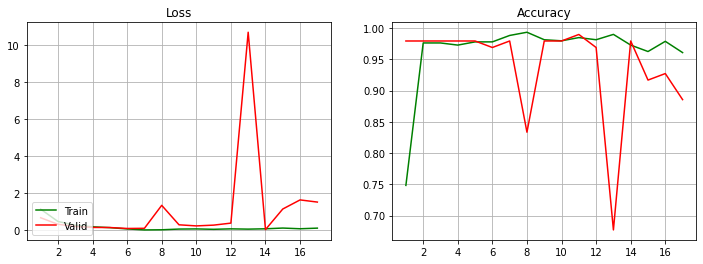

In [ ]:
setup_to_finetune(model, args, not_trainable=76)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 2,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

ft96_history = process_and_display(history, tl_history)
model.save_weights('/content/drive/MyDrive/checkpoints/fine_tuning_76')

Epoch 1/2
19/19 [==============================] - 24s 893ms/step - loss: 0.0669 - accuracy: 0.9842 - val_loss: 8.4843 - val_accuracy: 0.7292
Epoch 2/2
19/19 [==============================] - 17s 868ms/step - loss: 0.0554 - accuracy: 0.9839 - val_loss: 6.8331 - val_accuracy: 0.8646


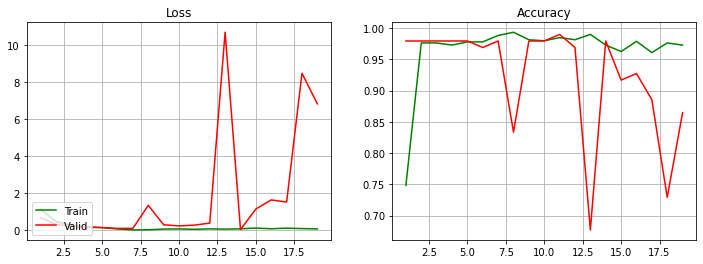

In [ ]:
model.layers[66].get_config()['name']
setup_to_finetune(model, args, not_trainable=66)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 2,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

ft96_history = process_and_display(history, tl_history)
model.save_weights('/content/drive/MyDrive/checkpoints/fine_tuning_66')

block8_sepconv1_act


# Save the final model

In [11]:
model.load_weights('/content/drive/MyDrive/checkpoints/fine_tuning_126')
model.save('/content/drive/MyDrive/checkpoints/final')

KeyboardInterrupt: ignored

# TEST SCORES

In [12]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/checkpoints/final')

In [13]:
nb_test_samples = get_nb_files(args.test_dir)
test_steps = int (nb_test_samples / args.batch_size)
model.evaluate(test_generator, steps=test_steps)

3/3 [==============================] - 18s 5s/step - loss: 0.0221 - accuracy: 0.9896


[0.02213904820382595, 0.9895833134651184]

# TO DO
Show examples how your model works with real images. 
Try to display:
- An image
- Real class of an image
- Estimated class of an image
- Probabilities

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


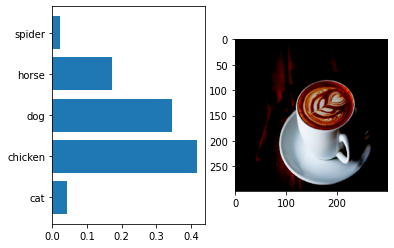

In [19]:
from keras.preprocessing.image import load_img, img_to_array
def predict_and_plot(model, img_path):
  image = load_img(img_path, target_size=(args.im_height, args.im_width))
  image=img_to_array(image)
 # plt.imshow(image/255.)

  image=preprocess_input(image)
  predictions=model.predict(np.array([image]))
  #print(predictions[0][2])
  #plt.barh(classes, predictions[0])
 
  plt.figure()

  plt.subplot(121)
  plt.barh(classes, predictions[0])


  plt.subplot(122)
  plt.imshow(image)
  






predict_and_plot(model, '/content/drive/MyDrive/RealSamples/coffee.jpg')